In [2]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
import math
import csv

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import pi
from scipy.fftpack import fft

LOG.propagate = False

233


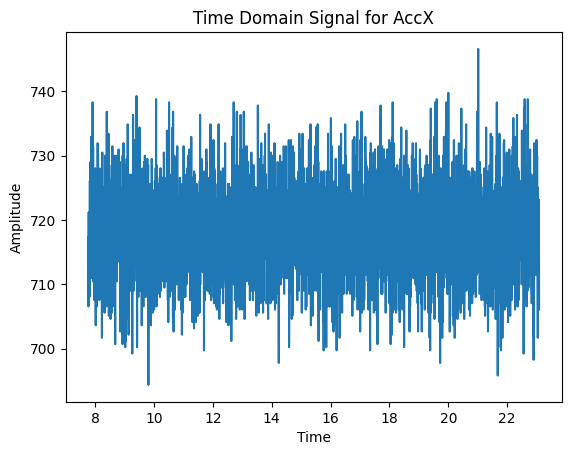

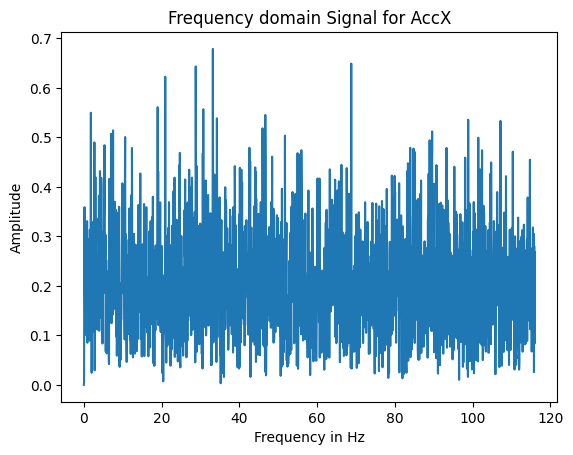

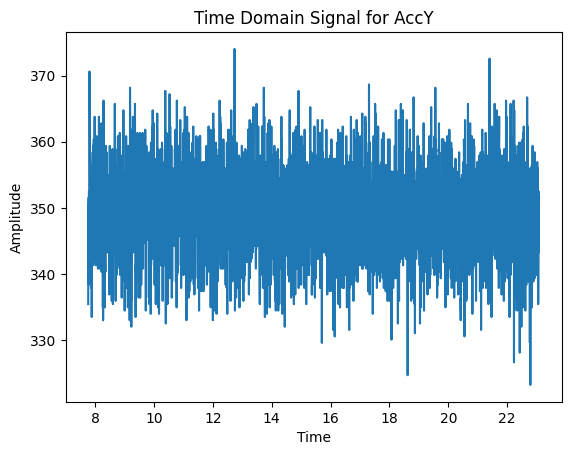

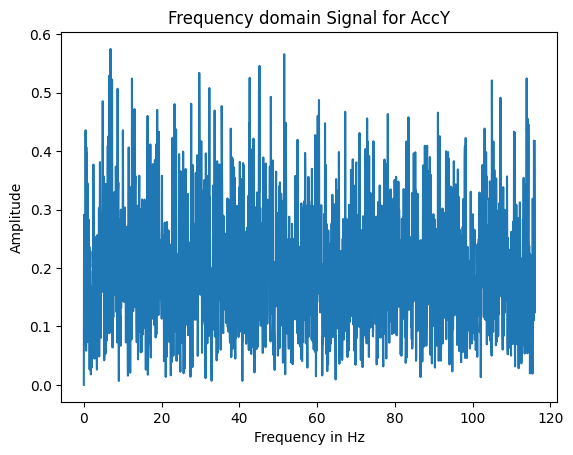

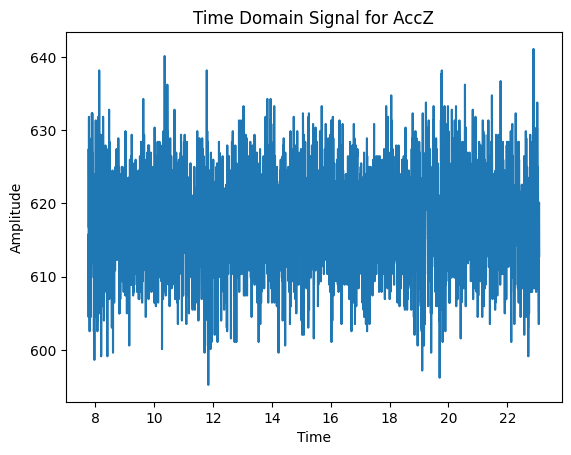

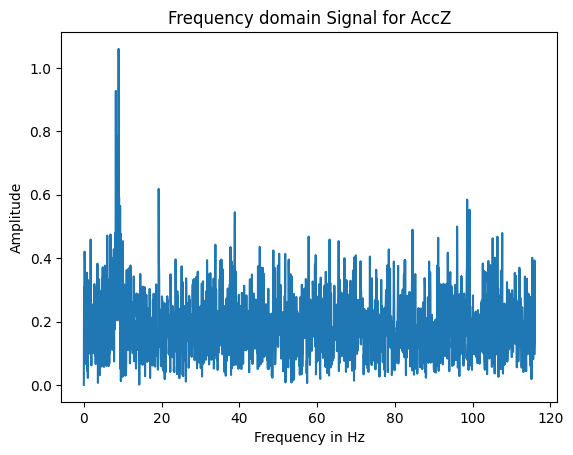

In [58]:
arr = np.loadtxt("acc_noise_data_fast.csv",
                 delimiter=",", dtype=str)
arr = arr[1:, :].astype(float)
#display(arr[1100:1200, :])

sample_rate = int(len(arr) /  (arr[len(arr)-1, 0] - arr[0, 0] ))
N = len(arr)
print(sample_rate)

frequency = np.linspace(0.0, int(sample_rate / 2), int(N/2))

for i in range(1, 4):
    axis = ["t", "X", "Y", "Z"]
    plt.plot(arr[:, 0], arr[:, i])
    plt.title ('Time Domain Signal for Acc' + axis[i])
    plt.xlabel ('Time')
    plt.ylabel ('Amplitude')
    plt.show()
    zeroed = arr[:, i] - np.average(arr[:, i])
    freq_data = fft(zeroed)
    y = 2/N * np.abs (freq_data [0: int (N/2)])
    plt.plot(frequency, y)
    plt.title('Frequency domain Signal for Acc' + axis[i])
    plt.xlabel('Frequency in Hz')
    plt.ylabel('Amplitude')
    plt.show()

In [31]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

ble.send_command(CMD.PING, "")
s = ble.receive_string(ble.uuid['RX_STRING'])
print(s)

2023-02-21 15:13:02,591 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:83:0c:66:2f:3c


Exception: Could not find device with address: c0:83:0c:66:2f:3c and service uuid: f74736e0-f5ac-4541-959d-e6c1f1b3f55c

In [37]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

readingsA = []
readingsB = []
timeStamps = []

complete = False

def handler(sender, msg):
    msg = msg.decode("utf-8")
    if msg == "<END BUFFER: ACCEL>" or msg == "<END BUFFER: TOF>":
        complete = True;
    print(msg)

ble.send_command(CMD.ENABLE_BUFFER, "ACCEL")
ble.send_command(CMD.ENABLE_BUFFER, "TOF")
time.sleep(5)
ble.send_command(CMD.DISABLE_BUFFER, "ACCEL")
ble.send_command(CMD.DISABLE_BUFFER, "TOF")
ble.start_notify(ble.uuid['RX_STRING'], handler)
ble.send_command(CMD.RETRIEVE_BUFFER, "ACCEL")
ble.send_command(CMD.RETRIEVE_BUFFER, "TOF")

2023-02-21 15:49:05,845 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:83:0c:66:2f:3c
2023-02-21 15:49:09,321 | INFO     |: Connected to c0:83:0c:66:2f:3c
<START BUFFER: ACCEL>
Time: 7499 | X: -155.273 | Y: 164.550 | Z: 990.722
Time: 7503 | X: -155.761 | Y: 172.851 | Z: 999.511
Time: 7507 | X: -152.343 | Y: 157.226 | Z: 992.675
Time: 7513 | X: -156.250 | Y: 158.691 | Z: 993.652
Time: 7517 | X: -174.804 | Y: 164.62 | Z: 993.652
Time: 7523 | X: -159.667 | Y: 166.992 | Z: 1003.906
Time: 7527 | X: -168.945 | Y: 154.296 | Z: 1002.929
Time: 7531 | X: -165.527 | Y: 164.550 | Z: 1007.812
Time: 7540 | X: -151.855 | Y: 175.781 | Z: 991.210
Time: 7546 | X: -162.597 | Y: 165.527 | Z: 999.23
Time: 7550 | X: -156.738 | Y: 170.898 | Z: 995.117
Time: 7556 | X: -161.621 | Y: 162.109 | Z: 1012.695
Time: 7559 | X: -166.15 | Y: 165.527 | Z: 1002.929
Time: 7563 | X: -164.62 | Y: 169.433 | Z: 1000.976
Time: 7566 | X: -166.992 | Y: 174.316 | Z: 987.792
Time: 7570 | X: -154.296 | Y: 165.39 | Z: 